In [1]:
import numpy as np
import torch
from torchvision import transforms as T
from models import bird_model, load_regressor, load_regressor_new
from utils.vis_bird import render_sample, render_sample_new
from datasets import Cowbird_Dataset
from keypoint_detection import load_detector, postprocess

%load_ext autoreload
%autoreload 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/home/lai/anaconda3/envs/avian/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
bird = bird_model()
regressor = load_regressor().to(device)
predictor = load_detector().to(device)

In [3]:
regressor_new = load_regressor_new().to(device)

In [4]:
normalize = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.406, 0.456, 0.485], std=[0.225, 0.224, 0.229])
    ])
unnormalize = T.Compose([
    T.Normalize(mean=[0, 0, 0], std=[1/0.225, 1/0.224, 1/0.229]),
    T.Normalize(mean=[-0.406, -0.456, -0.485], std=[1, 1, 1])
    ])
valid_set = Cowbird_Dataset('data/cowbird/images', 'data/cowbird/annotations/instance_test.json', transform=normalize)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [5]:
poses = []
# trans = []
bones = []

poses_new = []
# trans_new = []
bones_new = []

for i in range(len(valid_set)):
    imgs, target_kpts, target_masks, meta = valid_set[i]
    imgs = imgs[None]
    with torch.no_grad():
        # Prediction
        output = predictor(imgs.to(device))
        pred_kpts, pred_mask = postprocess(output)
        # print(pred_kpts)
        # print(pred_kpts.shape)
        # Regression
        kpts_in = pred_kpts.reshape(pred_kpts.shape[0], -1)
        # print(kpts_in.shape)
        mask_in = pred_mask
        p_est, b_est = regressor(kpts_in, mask_in)
        # print(p_est.shape, b_est.shape)
        pose, tran, bone = regressor.postprocess(p_est, b_est)
        poses.append(p_est.squeeze().cpu().numpy())
        # trans.append(tran.squeeze().cpu().numpy())
        bones.append(b_est.squeeze().cpu().numpy())
        # print(pose.shape, tran.shape, bone.shape)

        p_est, b_est = regressor_new(kpts_in, mask_in)
        # print(p_est.shape, b_est.shape)
        pose, tran, bone = regressor.postprocess(p_est, b_est)
        poses_new.append(p_est.squeeze().cpu().numpy())
        # trans.append(tran.squeeze().cpu().numpy())
        bones_new.append(b_est.squeeze().cpu().numpy())

/home/lai/avian-mesh/keypoint_detection/load_detector.py:49: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  pred_kpts[:,:,1] = 4*(ind//w)


In [13]:
poses_np = np.asarray(poses)
poses_new_np = np.asarray(poses_new)

poses_diff = np.sum(np.abs(poses_np - poses_new_np)) / len(valid_set) / poses_np.shape[1]
print(poses_diff)

0.46499486467649925


In [15]:
bones_np = np.asarray(bones)
bones_new_np = np.asarray(bones_new)

bones_diff = np.sum(np.abs(bones_np - bones_new_np)) / len(valid_set) / bones_np.shape[1]
print(bones_diff)

0.10089148136607388


In [8]:
import torch
from models import bird_model, load_regressor
from utils.vis_bird import render_sample, render_sample_new
from optimization import OptimizeSV, base_renderer
from matplotlib import pyplot as plt

imgs = []
imgs_new = []

for i in range(len(valid_set)):
    p_est = torch.from_numpy(poses[i][None, :])
    b_est = torch.from_numpy(bones[i][None, :])

    p_est_new = torch.from_numpy(poses_new[i][None, :])
    b_est_new = torch.from_numpy(bones_new[i][None, :])

    pose, tran, bone = regressor.postprocess(p_est, b_est)
    pose_new, tran_new, bone_new = regressor.postprocess(p_est_new, b_est_new)
    # print(pose.shape, tran.shape, bone.shape)

    optimizer = OptimizeSV(num_iters=0, prior_weight=1, mask_weight=1, 
                                use_mask=False, device=device)

    global_t = tran.clone()
    bone_length = bone.clone()

    init_pose = optimizer.transform_p(pose)
    global_orient = init_pose.clone()[:, :3]
    body_pose = init_pose.clone()[:, 3:]

    bird_output = bird(global_orient, body_pose, bone_length)
    global_txyz = optimizer.transform_t(global_t)

    model_mesh = bird_output['vertices'] + global_txyz.unsqueeze(1).to(torch.float)

    # print(bird_output.shape)

    img_opt, mask = render_sample_new(bird, model_mesh[0])

    global_t = tran_new.clone()
    bone_length = bone_new.clone()

    init_pose = optimizer.transform_p(pose_new)
    global_orient = init_pose.clone()[:, :3]
    body_pose = init_pose.clone()[:, 3:]

    bird_output = bird(global_orient, body_pose, bone_length)
    global_txyz = optimizer.transform_t(global_t)

    model_mesh = bird_output['vertices'] + global_txyz.unsqueeze(1).to(torch.float)

    # print(bird_output.shape)

    img_opt_new, mask_new = render_sample_new(bird, model_mesh[0])
    imgs.append(img_opt.cpu().numpy())
    imgs_new.append(img_opt_new.cpu().numpy())
    

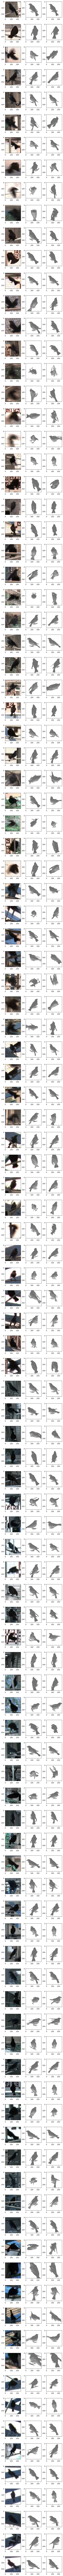

In [11]:
from torchvision.transforms import functional as F
fig, axs = plt.subplots(ncols=3, nrows=len(valid_set), figsize=(5.5, len(valid_set) * 2),
                        layout="constrained")

for row in range(len(valid_set)):
    axs[row, 0].imshow(F.to_pil_image(unnormalize(valid_set[row][0])))
    axs[row, 1].imshow(imgs[row])
    axs[row, 2].imshow(imgs_new[row])

In [ ]:
fig.show()

In [ ]:
print(poses)

In [ ]:
# Gaussian to pose
# Noise to bone

"""
we fit a
multivariate Gaussian to the estimated pose parameters (pose, viewpoint, and
translation). We then sample 100 random points from this distribution for each
bird instance, project the corresponding model's visible keypoints onto the camera 
and render the silhouette, generating 14,000 synthetic instances for training.
We keep the bone lengths of the original 140 instances, but add in random noise
to the bone lengths for each sample.
"""

In [ ]:
poses = np.asarray(poses)
bones = np.asarray(bones)

poses.shape, bones.shape

In [ ]:
# from sklearn import decomposition, mixture
# from matplotlib import pyplot as plt


In [ ]:
losses = []
i_s = []
mu = np.average(poses, axis=0)
for i in range(2, 114):
    pca = decomposition.PCA(n_components=i)
    poses_pca = pca.fit(poses)
    nComp = i
    Xhat = np.dot(pca.transform(poses)[:,:nComp], pca.components_[:nComp,:])
    Xhat += mu
    # print(Xhat.shape, poses.shape)
    loss = np.sum(np.abs(poses - Xhat) ** 2)
    losses.append(loss)
    i_s.append(i)

In [ ]:
plt.plot(i_s, losses)
print(losses[19], losses[39], losses[79])

In [ ]:
# fit
mu, cov = np.mean(poses, axis=0), np.cov(poses, rowvar=0)
print(mu.shape, cov.shape)

In [ ]:
# sample
sample = np.random.multivariate_normal(mu, cov, size=100000)
print(sample.shape)

In [ ]:
mu_bone = np.mean(bones, axis=0)
print(mu_bone.shape)

In [ ]:
import torch
from models import bird_model, load_regressor
from utils.vis_bird import render_sample, render_sample_new
from optimization import OptimizeSV, base_renderer
sample = np.random.multivariate_normal(mu, cov, size=1)
p_est = sample[0][None,:]
b_est = (bones[0] + np.random.normal(loc=0, size=(24), scale=0.2))[None,:]
print(p_est.shape, b_est.shape)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
bird = bird_model()

p_est = torch.from_numpy(p_est)
b_est = torch.from_numpy(b_est)

pose, tran, bone = regressor.postprocess(p_est, b_est)
print(pose.shape, tran.shape, bone.shape)

optimizer = OptimizeSV(num_iters=0, prior_weight=1, mask_weight=1, 
                               use_mask=False, device=device)

global_t = tran.clone()
bone_length = bone.clone()

init_pose = optimizer.transform_p(pose)
global_orient = init_pose.clone()[:, :3]
body_pose = init_pose.clone()[:, 3:]

bird_output = bird(global_orient, body_pose, bone_length)
global_txyz = optimizer.transform_t(global_t)

model_mesh = bird_output['vertices'] + global_txyz.unsqueeze(1).to(torch.float)

# print(bird_output.shape)

img_opt, mask = render_sample_new(bird, model_mesh[0])


In [ ]:
plt.imshow(img_opt)

In [ ]:
plt.imshow(mask, cmap='gray')

In [ ]:
print(global_txyz.unsqueeze(1).to(torch.float))

In [ ]:
print(bird_output.keys())

In [ ]:
print(bird_output['keypoints'] + global_txyz.unsqueeze(1).to(torch.float))

In [ ]:
from utils.renderer_p3d import RendererP3D

kps = bird_output['keypoints'] + global_txyz.unsqueeze(1).to(torch.float)

render = RendererP3D(faces=bird.dd['F'])
cameras = render.cameras

from utils.geometry import perspective_projection

print(cameras.get_projection_transform().transform_points(kps))

proj_kps = perspective_projection(kps, None, None, 2167, 128, None)
print(proj_kps)

In [ ]:
plt.imshow(img_opt)
plt.scatter(proj_kps.squeeze()[:,0], proj_kps.squeeze()[:,1])

In [ ]:
import torchvision.transforms.functional as F
from utils.img_utils import draw_kpts
# for i in range(len(valid_set)):
# 8, 20, 24, 29!
i = 0
imgs, target_kpts, target_masks, meta = valid_set[i]
imgs = unnormalize(imgs)
imgs = F.to_pil_image(imgs)
plt.imshow(imgs)
plt.scatter(target_kpts[:, 0], target_kpts[:, 1], c='red')

In [ ]:
from datasets.syn_dataset import synDataset
train_set = Cowbird_Dataset('data/cowbird/images', 'data/cowbird/annotations/instance_train.json', transform=normalize)
syn_dataset = synDataset(train_set)

# syn_dataset[0]

In [2]:
from datasets.syn_dataset import synDataset
syn_dataset = synDataset()
print(syn_dataset.masks.device)

cpu


In [3]:
test_int = syn_dataset[0]
# plt.scatter(test_int[2][:, 0], test_int[2][:, 1], c='red')
# plt.imshow(test_int[0])
# print(syn_dataset[0][0].shape)
print(test_int[1].shape, test_int[2].shape, test_int[3].shape, test_int[4].shape)

torch.Size([256, 256]) torch.Size([36]) torch.Size([153]) torch.Size([24])


In [ ]:
syn_dataset.pregen_dataset()

In [ ]:
test_int = syn_dataset[0]
# plt.scatter(test_int[2][:, 0], test_int[2][:, 1], c='red')
# plt.imshow(test_int[0])
# print(syn_dataset[0][0].shape)


In [3]:
# define model loss and training process.
from models.mesh_regressor import mesh_regressor
from tqdm import tqdm

model = mesh_regressor().to(device)
loss_fn = torch.nn.MSELoss()
dataloader = torch.utils.data.DataLoader(syn_dataset, 16, shuffle=True, num_workers=4)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model.train()

for epoch in tqdm(range(20)):
    loss_total = 0
    for i, data in enumerate(dataloader):
        _, mask, kps, p_gt, b_gt = data
        
        mask = mask.to(device)
        kps = kps.to(device)
        p_gt = p_gt.to(device)
        b_gt = b_gt.to(device)

        # print(mask.shape, kps.shape, p_gt.shape, b_gt.shape)

        pose_tran, bone = model(kps, mask)
        # print(pose_tran.shape, bone.shape)
        loss = loss_fn(pose_tran, p_gt) + loss_fn(bone, b_gt)
        loss_total += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
    batch_loss = loss_total / len(dataloader)
    print(f"Epoch {epoch+1}: {batch_loss}")

torch.save({'model_state_dict': model.state_dict()}, f"./models/regressor_{epoch+1}.pth")



  5%|▌         | 1/20 [00:12<03:49, 12.08s/it]

Epoch 1: 0.7873422171473503


 10%|█         | 2/20 [00:19<02:44,  9.12s/it]

Epoch 2: 0.19880252354485647


 15%|█▌        | 3/20 [00:25<02:13,  7.88s/it]

Epoch 3: 0.19019405910798481


 20%|██        | 4/20 [00:31<01:55,  7.25s/it]

Epoch 4: 0.1831665990097182


 25%|██▌       | 5/20 [00:38<01:43,  6.88s/it]

Epoch 5: 0.1823183789423534


 30%|███       | 6/20 [00:44<01:36,  6.89s/it]

Epoch 6: 0.1784296771798815


 35%|███▌      | 7/20 [00:51<01:27,  6.74s/it]

Epoch 7: 0.1741046981045178


 40%|████      | 8/20 [00:57<01:19,  6.67s/it]

Epoch 8: 0.1739591381549835


 45%|████▌     | 9/20 [01:04<01:13,  6.71s/it]

Epoch 9: 0.1713272386959621


 50%|█████     | 10/20 [01:11<01:07,  6.79s/it]

Epoch 10: 0.16811288192442486


 55%|█████▌    | 11/20 [01:18<01:00,  6.72s/it]

Epoch 11: 0.16755119025707244


 60%|██████    | 12/20 [01:25<00:54,  6.79s/it]

Epoch 12: 0.16684617257118226


 65%|██████▌   | 13/20 [01:31<00:46,  6.62s/it]

Epoch 13: 0.16454576142345156


 70%|███████   | 14/20 [01:37<00:39,  6.50s/it]

Epoch 14: 0.1633501228775297


 75%|███████▌  | 15/20 [01:43<00:31,  6.39s/it]

Epoch 15: 0.16267271929979324


 80%|████████  | 16/20 [01:49<00:25,  6.33s/it]

Epoch 16: 0.1614161280138152


 85%|████████▌ | 17/20 [01:56<00:19,  6.34s/it]

Epoch 17: 0.16069191769191196


 90%|█████████ | 18/20 [02:04<00:13,  6.95s/it]

Epoch 18: 0.1588140863435609


 95%|█████████▌| 19/20 [02:13<00:07,  7.44s/it]

Epoch 19: 0.1592910151907376


100%|██████████| 20/20 [02:19<00:00,  6.98s/it]

Epoch 20: 0.1576523453593254
